In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
from arch import arch_model

pd.set_option('display.float_format', '{:.2f}'.format)


# dataframe

In [156]:
'''
data_path = '/Users/xinc./Documents/GitHub/Quant_idea/data/0804 大社課 TXF 1m.csv'
df = pd.read_csv(data_path)
df.index = pd.to_datetime(df['datetime'])
df = df.drop(columns = ['Unnamed: 0', 'datetime', 'Date', 'Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
'''

## 資料DataFrame
df = yfin.download('^TWII', start = '2023-3-1', end = '2024-5-30')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
## 計算資料DataFrame
ret_df = pd.DataFrame(index = df.index)
## 績效DataFrame
equity = pd.DataFrame()


[*********************100%%**********************]  1 of 1 completed


# parameter & formula

In [157]:
data = df['close']
a = 0.9
p = 1
q = 1
num_vol = 1
rolling = 20
upper_threshold = 0.03
lower_threshold = 0.1
retrace_u_threshold = 0.05
retrace_l_threshold = 0.05
df['llt_slope'] = np.nan

def get_llt(data, a):
    llt = np.zeros(len(data))
    llt[0] = data.iloc[0]
    llt[1] = (1 - a) * data.iloc[0] + a * data.iloc[1]
    for n in range(2, len(data)):
        llt[n] = ((a - (a ** 2)/4) * data.iloc[n]) + (((a ** 2)/2) * data.iloc[n - 1]) - ((a - (3 * (a ** 2))/4) * data.iloc[n - 2]) + ((2 * (1 - a)) * llt[n - 1]) - (((1 - a) ** 2) * llt[n - 2])
    return llt

df['llt'] = get_llt(data, a)

for i in range(0, len(df)):
    df['llt_slope'].iloc[i] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]

def bolinger_band(data, num_vol):
    model = arch_model(df['llt'].dropna(), vol = 'Garch', p = p, q = q)
    garch_fit = model.fit(disp = 'off')
    df['garch_volitility'] = garch_fit.conditional_volatility

    df['bolinger_upper'] = df['llt'] + num_vol * df['garch_volitility']
    df['bolinger_lower'] = df['llt'] - num_vol * df['garch_volitility']

    df['bolinger_upper_smooth'] = df['bolinger_upper'].ewm(span = 20).mean()
    df['bolinger_lower_smooth'] = df['bolinger_lower'].ewm(span = 20).mean()

    df['upper_max'] = df['bolinger_upper'].rolling(window = rolling).max()
    df['lower_min'] = df['bolinger_lower'].rolling(window = rolling).min()

    df['upper_retrace'] = (df['upper_max'] - df['bolinger_upper']) / df['upper_max']
    df['lower_retrace'] = (df['bolinger_lower'] - df['lower_min']) / df['lower_min']

    df['upper_deviation'] = (df['bolinger_upper'] - df['close']) / df['close']
    df['lower_deviation'] = (df['close'] - df['bolinger_lower']) / df['close']

    df['upper_rise'] = df['upper_deviation'] >= upper_threshold
    df['lower_down'] = df['lower_deviation'] >= lower_threshold
    df['upper_down'] = df['upper_retrace'] >= retrace_u_threshold
    df['lower_rise'] = df['lower_retrace'] >= retrace_l_threshold

    df['mean'] = df['close'].mean()
    # for i in range(len(df)):
    #     df['mean'].iloc[i] = (df['close'].mean())
    

    return df

df = bolinger_band(data, num_vol)



304


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/3404745615.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['llt_slope'].iloc[i] = df['llt'].iloc[i] - df['llt'].iloc[i - 1]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000

# strategy

## long & short


In [158]:

BS = None
fund = 1000000
feePaid = 600
ret_df['BS'] = None
df['Bull'] = False
df['Bear'] = False
ret_df['position'] = np.zeros(len(df))
ret_df['buy_price'] = np.zeros(len(df))
ret_df['sell_price'] = np.zeros(len(df))
ret_df['buy'] = np.zeros(len(df))
ret_df['sell'] = np.zeros(len(df))
ret_df['sellshort'] = np.zeros(len(df))
ret_df['buytocover'] = np.zeros(len(df))
ret_df['profit_list'] = np.zeros(len(df))
ret_df['profit_fee_list'] = np.zeros(len(df))
ret_df['profit_fee_list_realized'] = np.zeros(len(df))

for i in range(2, len(df)):
    if i == len(df) - 1:
        break
    
    condition1 = (df['bolinger_upper_smooth'].iloc[i] - df['mean'].iloc[i]) > (df['mean'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向上
    condition2 = (df['bolinger_upper_smooth'].iloc[i] - df['mean'].iloc[i]) < (df['mean'].iloc[i] - df['bolinger_lower_smooth'].iloc[i]) # 峰向下
    condition3 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) > 0 # 上軌向上
    condition4 = (df['bolinger_upper_smooth'].iloc[i] - df['bolinger_upper_smooth'].iloc[i - 1]) < 0 # 上軌向下
    condition5 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) > 0 # 下軌向上
    condition6 = (df['bolinger_lower_smooth'].iloc[i] - df['bolinger_lower_smooth'].iloc[i - 1]) < 0 # 下軌向下
    df['Bull'].iloc[i] = (condition1 & condition3) | (condition2 & condition5)
    df['Bear'].iloc[i] = (condition1 & condition4) | (condition2 & condition6)

    #Long
    if df['Bull'].iloc[i]:
        
        ## 進場邏輯
        entryLong = (df['llt_slope'].iloc[i] > 0) & (((df['upper_rise'].iloc[i] == True) & (condition1)) | ((df['lower_rise'].iloc[i] == True) & (condition2)))

        ##出場邏輯
        exitLong = (df['llt_slope'].iloc[i] < 0) & (((df['upper_down'].iloc[i] == True) & (condition1)) | ((df['lower_down'].iloc[i] == True) & (condition2)))


        if BS == None:
            if entryLong:
                BS = 'B'
                t = i + 1
                ret_df['buy'].iloc[t] = t
                ret_df['buy_price'].iloc[t] = df['open'].iloc[t]
                ret_df['position'].iloc[t] += 1
                # print(f'entry, {i}')

        elif BS == 'B':
            # print(f'state: B, {i}')

            ret_df['position'].iloc[i + 1] = ret_df['position'].iloc[i]
            profit = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[i]) * ret_df['position'].iloc[i + 1]
            ret_df['profit_list'].iloc[i + 1] = profit

            if exitLong or i == len(df) - 2:
                # print(f'exit, {i}')
                pl_round = 200 * (df['open'].iloc[i + 1] - df['open'].iloc[t])
                profit_fee = profit - feePaid * 2
                ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
                ret_df['sell_price'].iloc[i + 1] = df['open'].iloc[i + 1]
                ret_df['sell'].iloc[i + 1] = i + 1

                BS = None

                ret_df['profit_fee_list_realized'].iloc[i + 1] = pl_round - feePaid * 2

            else:
                profit_fee = profit
                ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
    #Short
    # elif df['Bear'].iloc[i]:
        
    #     ## 進場邏輯
    #     entryShort = (df['llt_slope'].iloc[i] < 0) & ((df['lower_down'].iloc[i] == True) | (df['upper_down'].iloc[i] == True))

    #     ## 出場邏輯
    #     exitShort = (df['llt_slope'].iloc[i] > 0) & ((df['upper_rise'].iloc[i] == True) | (df['lower_rise'].iloc[i] == True))

    #     if BS == None:
    #         if entryShort:
    #             BS = 'S'
    #             t = i + 1
    #             ret_df['sellshort'].iloc[t] = t

    #     elif BS == 'S':
    #         profit = 200 * (df['open'].iloc[i] - df['open'].iloc[i + 1])
    #         ret_df['profit_list'].iloc[i] = profit

    #         if exitShort | i == len(df) - 2:
    #             pl_round = 200 * (df['open'].iloc[t] - df['open'].iloc[i + 1])
    #             profit_fee = profit - feePaid * 2
    #             ret_df['profit_fee_list'].iloc[i] = profit_fee
    #             ret_df['buytocover'].iloc[i + 1] = i + 1
    #             BS = None

    #             profit_fee_realized = pl_round - feePaid * 2
    #             ret_df['profit_fee_list_realized'].iloc[i] = profit_fee_realized

    #         else:
    #             profit_fee = profit
    #             ret_df['profit_fee_list'].iloc[i] = profit_fee
    # else:
    #     continue

df['strategy_ret'] = ret_df['profit_list'].cumsum()
equity['profitfee'] = ret_df['profit_fee_list'].cumsum()


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/1277374336.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Bull'].iloc[i] = (condition1 & condition3) | (condition2 & condition5)
/var/folders/0j/sdf7gd116kd5lv12gdjc8

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/1277374336.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret_df['profit_fee_list'].iloc[i + 1] = profit_fee
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/1277374336.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] 

In [159]:
df

,open,high,low,close,adj_close,volume,llt_slope,llt,garch_volitility,bolinger_upper,...,upper_deviation,lower_deviation,upper_rise,lower_down,upper_down,lower_rise,mean,Bull,Bear,strategy_ret
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-01,15435.38,15617.03,15387.38,15598.49,15598.49,3062600,-6148.53,15598.49,1754.26,17352.75,...,0.11,0.11,True,True,False,False,17497.55,False,False,0.00
2023-03-02,15580.28,15618.06,15492.37,15598.72,15598.72,2664900,0.21,15598.70,1117.90,16716.60,...,0.07,0.07,True,False,False,False,17497.55,False,False,0.00
2023-03-03,15621.36,15713.42,15606.85,15608.42,15608.42,3025100,6.85,15605.55,1117.71,16723.26,...,0.07,0.07,True,False,False,False,17497.55,True,False,0.00
2023-03-06,15675.28,15818.88,15675.28,15763.51,15763.51,3095600,113.41,15718.96,1111.33,16830.29,...,0.07,0.07,True,False,False,False,17497.55,True,False,0.00
2023-03-07,15763.87,15879.16,15749.04,15857.89,15857.89,2944000,148.42,15867.37,1006.13,16873.50,...,0.06,0.06,True,False,False,False,17497.55,True,False,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,21668.84,21668.84,21475.99,21607.43,21607.43,5498400,216.56,21665.15,4476.40,26141.55,...,0.21,0.20,True,True,False,False,17497.55,True,False,-20548.05
2024-05-24,21442.67,21608.72,21381.25,21565.34,21565.34,4233200,-57.68,21607.47,4682.10,26289.56,...,0.22,0.22,True,True,False,False,17497.55,True,False,-20548.05
2024-05-27,21699.98,21871.34,21699.98,21803.77,21803.77,4877400,119.29,21726.76,4627.31,26354.07,...,0.21,0.22,True,True,False,False,17497.55,True,False,-20548.05


## short

In [160]:
'''
BS = None
Trend = None
fund = 1000000
feePaid = 600
ret_df['profit_list'] = np.zeros(len(df))
ret_df['profit_fee_list'] = np.zeros(len(df))
ret_df['profit_fee_list_realized'] = np.zeros(len(df))
ret_df['buy'] = 0
ret_df['sell'] = 0
ret_df['sellshort'] = np.zeros(len(df))
ret_df['buytocover'] = np.zeros(len(df))

for i in range(len(df) - 1):

    ## 進場邏輯
    entryShort = (df['llt_slope'].iloc[i] < 0) & ((df['lower_down'].iloc[i] == True) | (df['lower_down'].iloc[i] == True))

    ## 出場邏輯
    exitShort = (df['llt_slope'].iloc[i] > 0) & ((df['upper_rise'].iloc[i] == True) | (df['lower_rise'].iloc[i] == True))

    if BS == None:
        if entryShort:
            BS = 'S'
            t = i + 1
            ret_df['sellshort'].iloc[t] = t

    elif BS == 'S':
        profit = 200 * (df['open'].iloc[i] - df['open'].iloc[i + 1])
        ret_df['profit_list'].iloc[i] = profit

        if exitShort | i == len(df) - 2:
            pl_round = 200 * (df['open'].iloc[t] - df['open'].iloc[i + 1])
            profit_fee = profit - feePaid * 2
            ret_df['profit_fee_list'].iloc[i] = profit_fee
            ret_df['buytocover'].iloc[i + 1] = i + 1
            BS = None

            profit_fee_realized = pl_round - feePaid * 2
            ret_df['profit_fee_list_realized'].iloc[i] = profit_fee_realized

        else:
            profit_fee = profit
            ret_df['profit_fee_list'].iloc[i] = profit_fee

df['strategy_ret'] = ret_df['profit_list'].cumsum()
equity['profitfee'] = ret_df['profit_fee_list'].cumsum()
'''

"\nBS = None\nTrend = None\nfund = 1000000\nfeePaid = 600\nret_df['profit_list'] = np.zeros(len(df))\nret_df['profit_fee_list'] = np.zeros(len(df))\nret_df['profit_fee_list_realized'] = np.zeros(len(df))\nret_df['buy'] = 0\nret_df['sell'] = 0\nret_df['sellshort'] = np.zeros(len(df))\nret_df['buytocover'] = np.zeros(len(df))\n\nfor i in range(len(df) - 1):\n\n    ## 進場邏輯\n    entryShort = (df['llt_slope'].iloc[i] < 0) & ((df['lower_down'].iloc[i] == True) | (df['lower_down'].iloc[i] == True))\n\n    ## 出場邏輯\n    exitShort = (df['llt_slope'].iloc[i] > 0) & ((df['upper_rise'].iloc[i] == True) | (df['lower_rise'].iloc[i] == True))\n\n    if BS == None:\n        if entryShort:\n            BS = 'S'\n            t = i + 1\n            ret_df['sellshort'].iloc[t] = t\n\n    elif BS == 'S':\n        profit = 200 * (df['open'].iloc[i] - df['open'].iloc[i + 1])\n        ret_df['profit_list'].iloc[i] = profit\n\n        if exitShort | i == len(df) - 2:\n            pl_round = 200 * (df['open'].il

## 指數

In [161]:
ret_df['index_ret'] = np.zeros(len(df))

for i in range(1, len(df)):
    ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200

ret_df['cum_index_ret'] = ret_df['index_ret'].cumsum()

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/3050492744.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ret_df['index_ret'].iloc[i] = (df['open'].iloc[i] - df['open'].iloc[i - 1]) * 200
/var/folders/0j/sdf7gd116kd5lv1

# performance

In [162]:
risk_free_rate = 0.04/252
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = min((ret_df['buy'] > 0).sum(), (ret_df['sell'] > 0).sum())
winRate = len([i for i in ret_df['profit_fee_list_realized'] if i > 0]) / tradeTimes
profitFactor = sum([i for i in ret_df['profit_fee_list_realized'] if i>0]) / abs(sum([i for i in ret_df['profit_fee_list_realized'] if i<0]))
mean_ret = ret_df['profit_list'].mean()
std_ret = ret_df['profit_list'].std()
sharp = (mean_ret - risk_free_rate) / std_ret

print('Profit : ', profit)
print('Return : ', ret)
print('Max DrawDown : ', mdd)
print('Caimar Ratio : ', calmarRatio)
print('Trade Times : ', tradeTimes)
print('Win Rate : ', winRate)
print('Profit Factor : ', profitFactor)
print('Sharp Ratio : ', sharp)

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_93450/2780400321.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


ZeroDivisionError: float division by zero

# plot

## profit

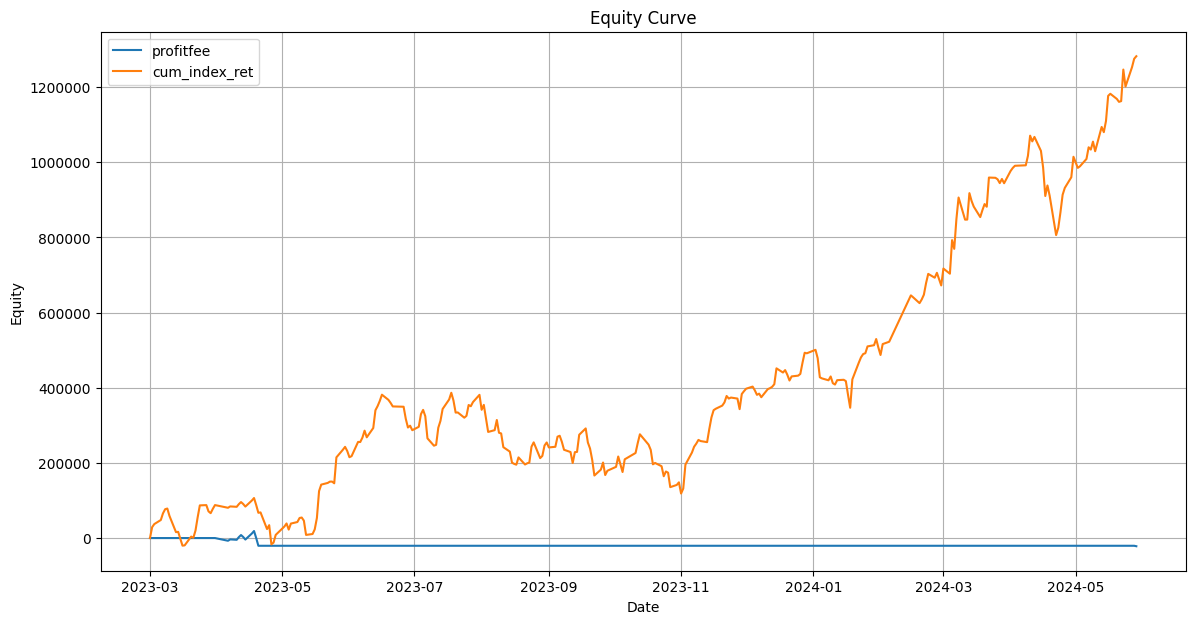

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df.index, equity['profitfee'], label='profitfee')
ax.plot(df.index, ret_df['cum_index_ret'], label='cum_index_ret')

## 设置纵轴刻度格式
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

## 添加网格、标签和标题
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title('Equity Curve')
ax.legend()

plt.show()


## 買賣點

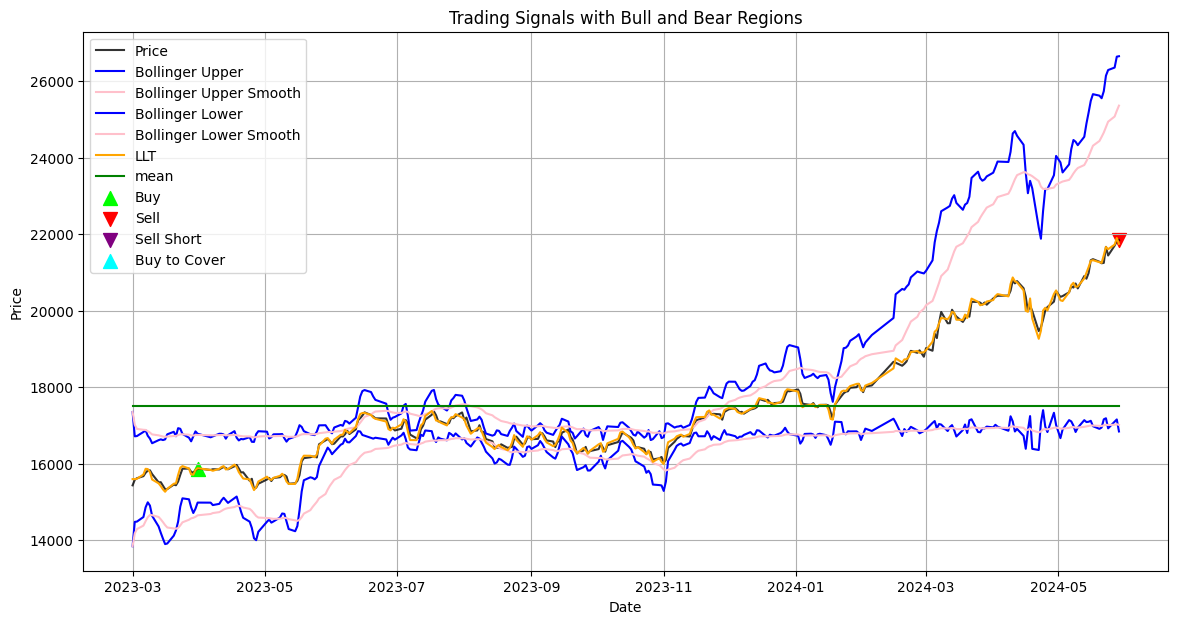

In [163]:
# 筛选买卖信号
buy_points = ret_df[ret_df['buy'] > 0]
sell_points = ret_df[ret_df['sell'] > 0]
sellshort_points = ret_df[ret_df['sellshort'] > 0]
buytocover_points = ret_df[ret_df['buytocover'] > 0]

# 绘制价格图表
plt.figure(figsize=(14, 7))

# 绘制价格线
plt.plot(df.index, df['open'], label='Price', color='black', alpha=0.8)

# 绘制布林带上轨线
plt.plot(df.index, df['bolinger_upper'], label='Bollinger Upper', color='blue')
plt.plot(df.index, df['bolinger_upper_smooth'], label='Bollinger Upper Smooth', color='pink')

# 绘制布林带下轨线
plt.plot(df.index, df['bolinger_lower'], label='Bollinger Lower', color='blue')
plt.plot(df.index, df['bolinger_lower_smooth'], label='Bollinger Lower Smooth', color='pink')

# 绘制LLT线
plt.plot(df.index, df['llt'], label='LLT', color='orange')

# 绘制中线
plt.plot(df.index, df['mean'], label='mean', color='green')

# # 绘制买入点
plt.scatter(buy_points.index, df['open'].loc[buy_points.index], color='lime', marker='^', label='Buy', s=100)

# # 绘制卖出点
plt.scatter(sell_points.index, df['open'].loc[sell_points.index], color='red', marker='v', label='Sell', s=100)

# # 绘制卖空点
plt.scatter(sellshort_points.index, df['open'].loc[sellshort_points.index], color='purple', marker='v', label='Sell Short', s=100)

# # 绘制买回点
plt.scatter(buytocover_points.index, df['open'].loc[buytocover_points.index], color='cyan', marker='^', label='Buy to Cover', s=100)

# # 绘制 Bull 和 Bear 区域
# bull_region_label_shown = False
# bear_region_label_shown = False
# for i in range(1, len(df)):
#     if df['Bull'].iloc[i]:
#         plt.fill_between(df.index[i-1:i+1], df['open'].min(), df['open'].max(), color='lightgreen', alpha=0.5, label='Bull Region' if not bull_region_label_shown else "")
#         bull_region_label_shown = True
#     if df['Bear'].iloc[i]:
#         plt.fill_between(df.index[i-1:i+1], df['open'].min(), df['open'].max(), color='lightcoral', alpha=0.5, label='Bear Region' if not bear_region_label_shown else "")
#         bear_region_label_shown = True

# 添加图例、标题和标签
plt.legend()
plt.title('Trading Signals with Bull and Bear Regions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [ ]:
ret_df[:50]

,BS,position,buy_price,sell_price,buy,sell,sellshort,buytocover,profit_list,profit_fee_list,profit_fee_list_realized,index_ret,cum_index_ret
Date,,,,,,,,,,,,,
2023-03-01,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-03-02,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28980.08,28980.08
2023-03-03,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8216.02,37196.09
2023-03-06,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10783.98,47980.08
2023-03-07,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17717.97,65698.05
2023-03-08,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11061.91,76759.96
2023-03-09,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1760.16,78520.12
2023-03-10,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-19738.09,58782.03
2023-03-13,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-43051.95,15730.08


# optimize

In [ ]:
optimizationList = []
fund = 1000000
feePaid = 600
